# Aviation Risk Analysis

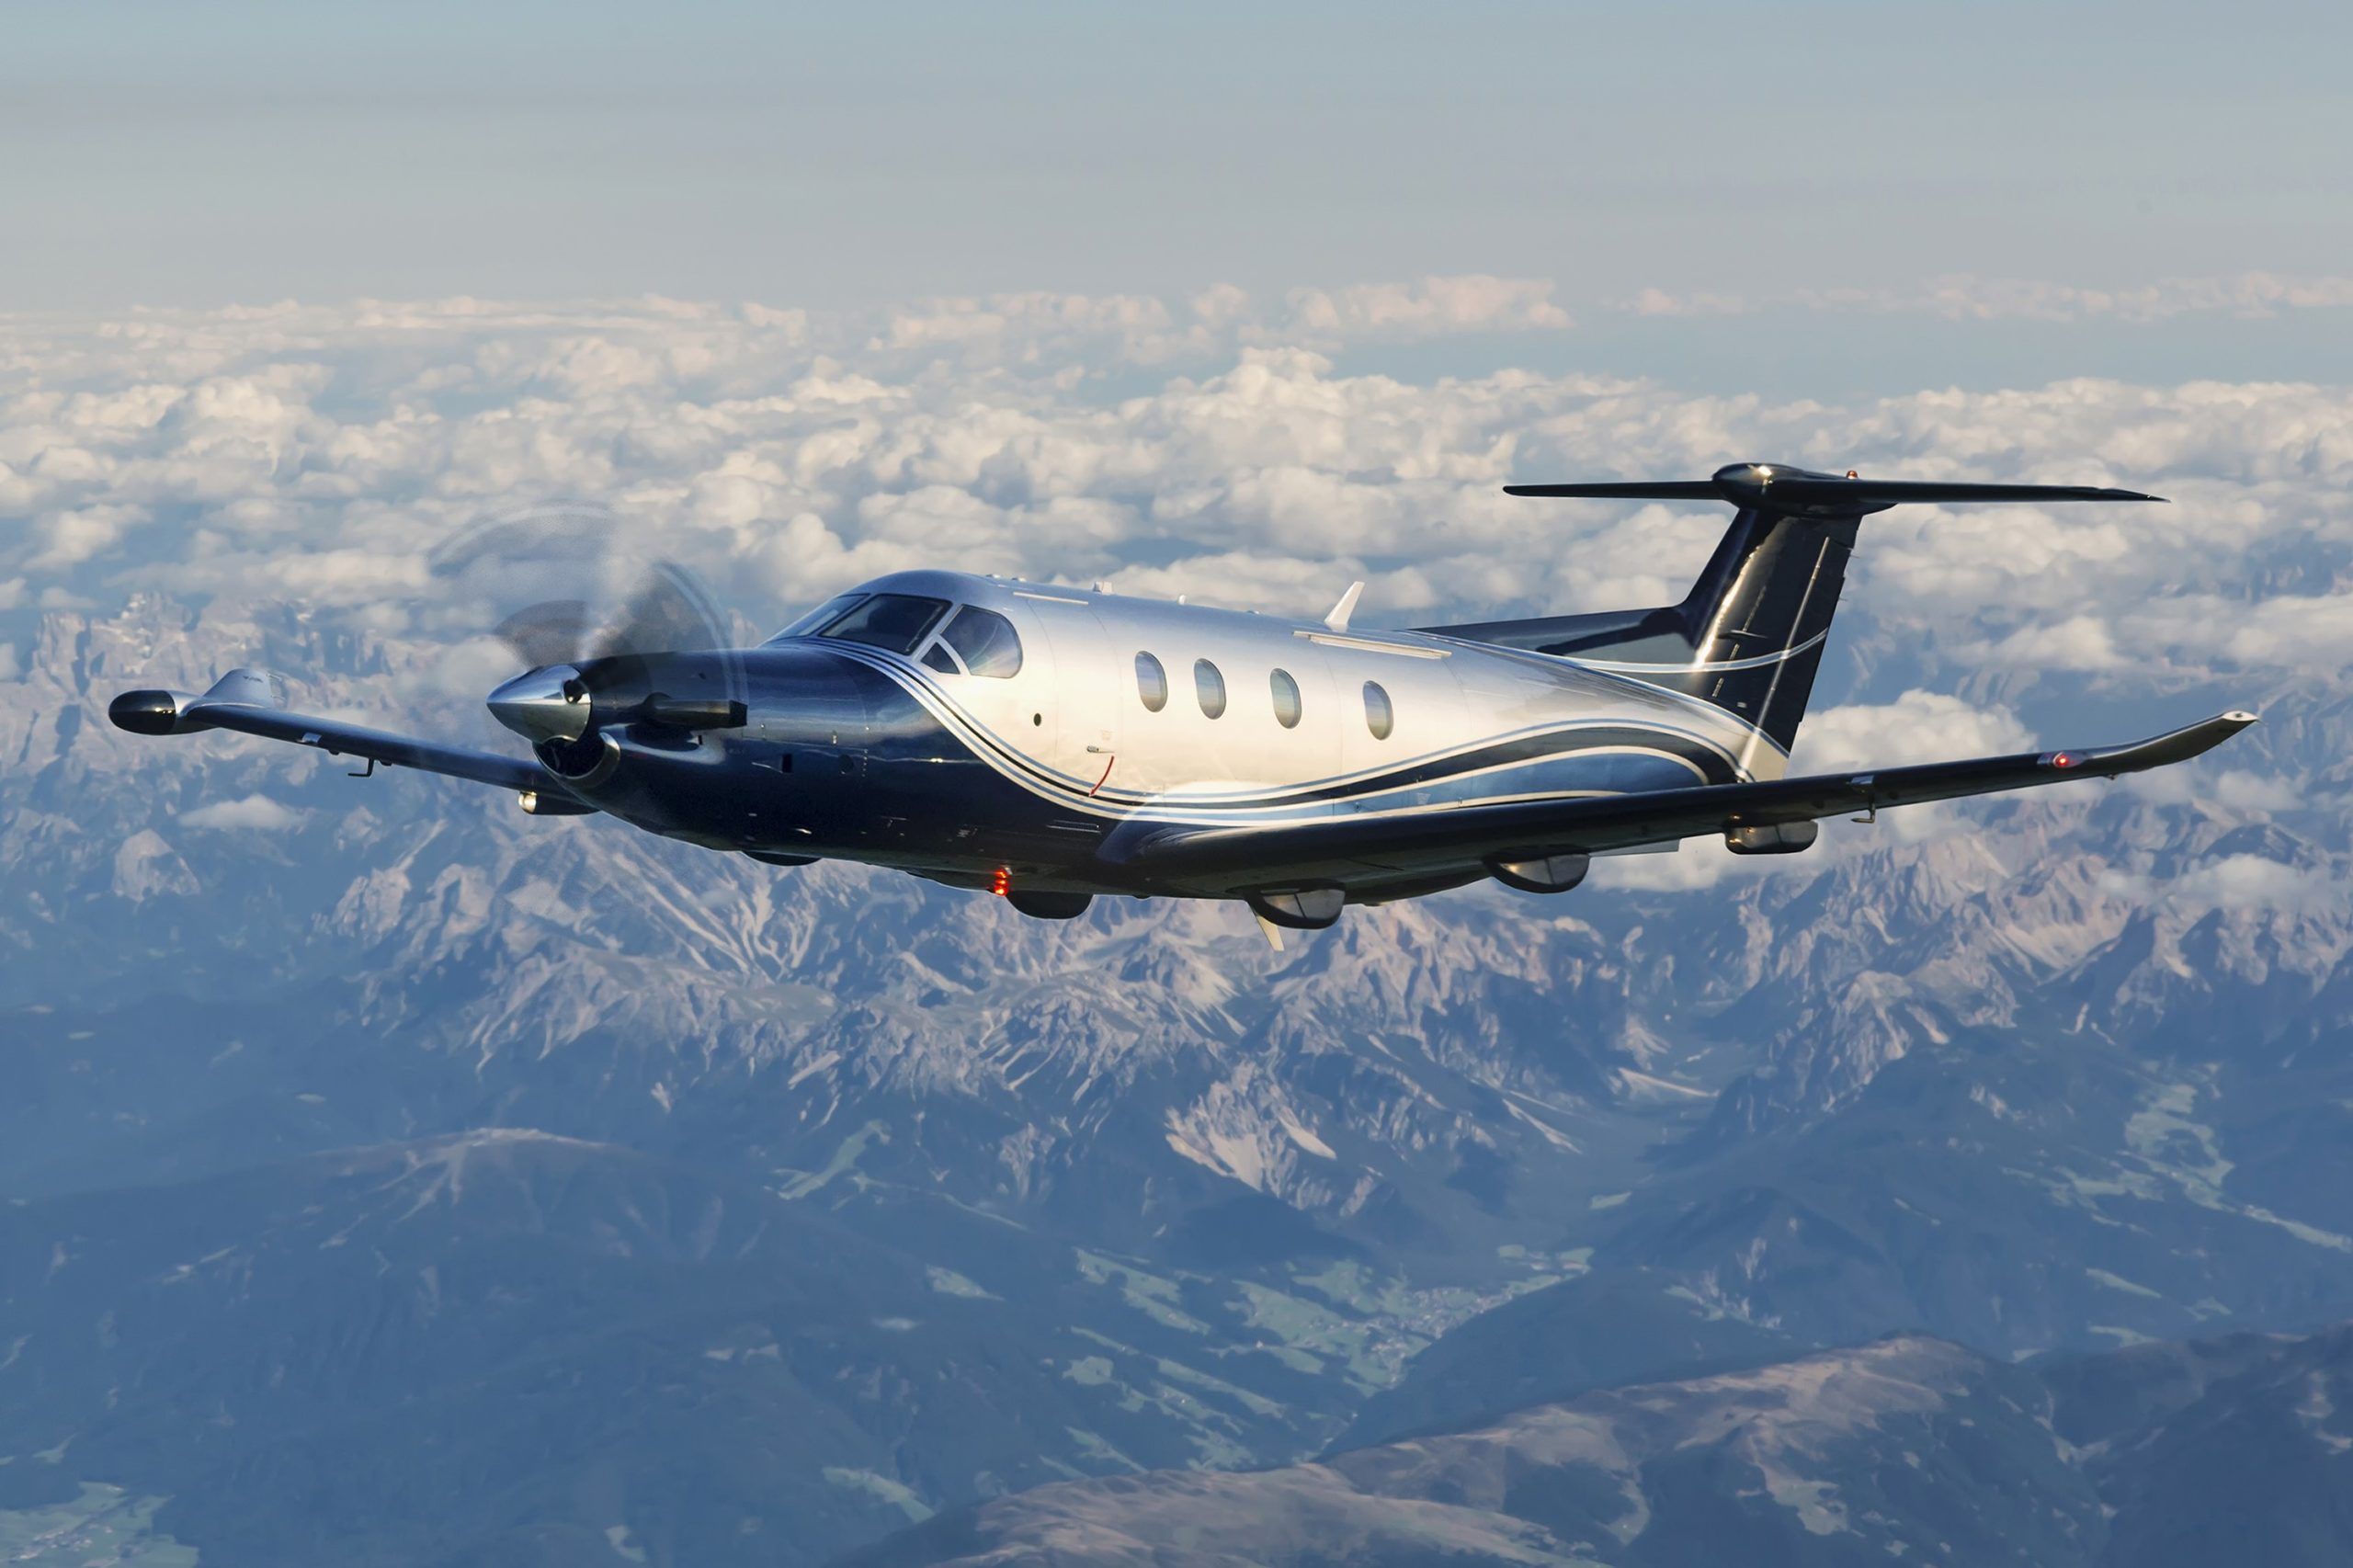

# Project Overview

This project analyzes airplane accidents from 2008 to 2022. This notebook showcases data cleaning, imputation, and analysis that generate relevant insights on key risks when purchasing a plane.

# Business Understanding 

The project brief stated that our company is expanding in to new industries to diversify its portfolio, and specifically interested in purchasing and operating airplanes for commercial and private enterprises. We will offer actionable insights on the lowest risk planes for the company to start this new business endeavor on a budget.

We began by asking

What is the budget for initial investment?

What variables effect risk the most?

How can we mitigate risk while working within a constrained budget?

# Data Understanding

The dataset comes from National Transportation Safety Board https://www.kaggle.com/datasets/khsamaha/aviation-accident-database-synopses  and accident data from 1962 to 2022 about civil aviation accidents and selected incidents in the United States and international waters.

Crashes can be tracked across qualitative data points, such as details about the aircraft (model, make, engine). Quantitative data is also available, notably allowing us to track engine numbers, TimeDates of incidents, and injury counts from the crashes.

For the purpose of our research, we filtered data based on below,

1) Airplanes only, 

2) Professionally built,

3) 2008-2022,

4) Serious and fatal injuries,

5) 14,100 datapoints, Initial datapoints were 89,900 data points 

6) the Top 10 manufacturers,

#### Data Limitations:
- No records on annual flights or make releases.
- The reason of accidents are not specifically clear.
- Inconsistent reporting in terms of aircraft category.

In [208]:
#importing pandas and matplotlib
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [209]:
#pulling csv file
state = pd.read_csv('./airplane_data/USState_Codes.csv')

aviation = pd.read_csv('./airplane_data/AviationData.csv', encoding='latin-1')

/Users/goknurkaya/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (6,7,28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Data Preparation and Analysis

## Data Cleaning

In [210]:
aviation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88889 entries, 0 to 88888
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      88889 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50249 non-null  object 
 9   Airport.Name            52790 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87572 non-null  object 
 14  Make                    88826 non-null

- We converted event date to year and limit only airplane since we want to expand our business for airplanes. Dropping missing values from number of engines and engine type. Lasly avoiding amateur bult airplanes.

In [211]:
# Filter data for years 2008 and later
aviation_2008["Year"] = aviation_2008["Event.Date"].map(lambda x: int(x[:4]))
aviation_2008["Year"] = aviation_2008["Year"].astype(int)
aviation_2008 = aviation_2008[aviation_2008["Year"] >= 2008]

# Filter for 'Aircraft.Category' == 'Airplane'
aviation_2008 = aviation_2008[aviation_2008["Aircraft.Category"] == "Airplane"]

# Drop rows with missing values in 'Number.of.Engines' and 'Engine.Type'
aviation_2008 = aviation_2008.dropna(subset=["Number.of.Engines", "Engine.Type"])

# Filter for 'Amateur.Built' == 'No' 
aviation_2008 = aviation_2008[aviation_2008['Amateur.Built'] == 'No']

## Frequency of accidents by year

- We investigated frequency of accidents by year to see if accidents amount changes or not.

<ipython-input-212-cb62edd4ad00>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(years, rotation = 90)


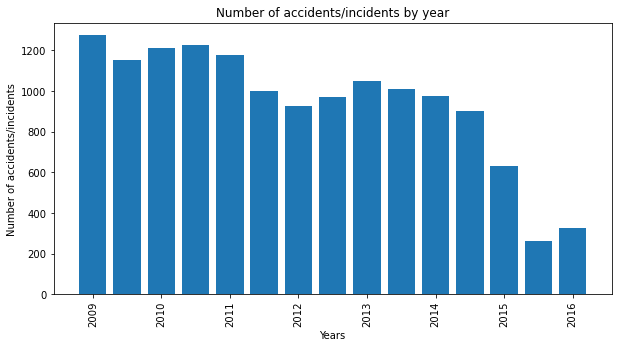

In [212]:
# Investigating frequency of accidents/incidents by year
years = aviation_2008["Year"].value_counts().sort_index().index
fre_years = aviation_2008["Year"].value_counts().sort_index().values

# Plotting
fig, ax = plt.subplots( figsize = (10, 5))
ax.bar(years, fre_years)
ax.set_xticklabels(years, rotation = 90)
ax.set_ylabel("Number of accidents/incidents")
ax.set_xlabel("Years")
ax.set_title("Number of accidents/incidents by year");

<ipython-input-213-a2067ecdb4b1>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(a_year, rotation=90)


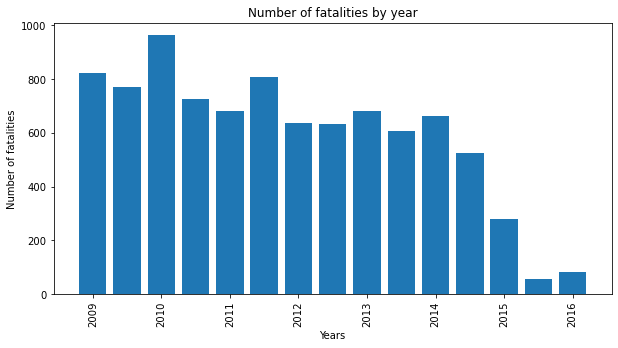

In [213]:
# Investigating fatality by year 
aviation_2008['Total_Injuries'] = aviation_2008['Total.Fatal.Injuries'] + aviation_2008['Total.Serious.Injuries']
a_year = aviation_2008.groupby("Year")["Total_Injuries"].sum().index

fatality = aviation_2008.groupby("Year")["Total_Injuries"].sum().values

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(a_year, fatality)
ax.set_xticklabels(a_year, rotation=90)
ax.set_ylabel("Number of fatalities")
ax.set_xlabel("Years")
ax.set_title("Number of fatalities by year");


In [214]:
# Percentage of Accidents/Incidents by Number of Engines
aviation_2008["Number.of.Engines"].value_counts(normalize = True)

1.0    0.843972
2.0    0.151348
4.0    0.003475
3.0    0.001064
8.0    0.000071
0.0    0.000071
Name: Number.of.Engines, dtype: float64

- As we can see above, most of accidents are reported due to being single engine because it is majority of our datasets. Followed by 2 engines.

In [215]:
# Percentage of Accidents/Incidents by Engine Type
aviation_2008["Engine.Type"].value_counts(normalize = True)

Reciprocating      0.864043
Turbo Prop         0.072908
Turbo Fan          0.052482
Turbo Jet          0.007730
Unknown            0.001206
Geared Turbofan    0.000780
Turbo Shaft        0.000426
Electric           0.000355
UNK                0.000071
Name: Engine.Type, dtype: float64

- Same story here. majority of engine type is reciprocating. Must be the main engine type to cause an accident.

### Creating 'Total_Injuries' column in dataframe summing fatal and serious injuries

#### Let's looks at the total injuries by number of engines 

In [231]:
#creating a total injury column
aviation_2008['Total_Injuries'] = aviation_2008['Total.Fatal.Injuries'] + aviation_2008['Total.Serious.Injuries']

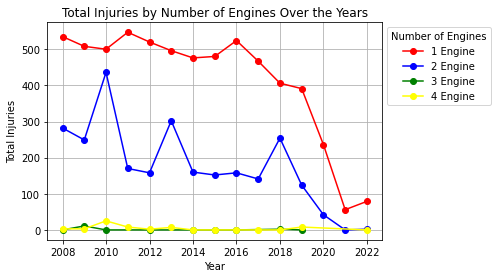

In [232]:
# Create a dictionary 'colors' that maps the number of engines to a color.
colors = {1: 'red', 2: 'blue', 3: 'green', 4: 'yellow'}

# Loop through the items (engine, color) in the 'colors' dictionary.
for engine, color in colors.items():
    
    # Filter the 'aviation_2008' DataFrame to select rows where the 'Number.of.Engines' column matches the current 'engine'.
    aviation_engine = aviation_2008[aviation_2008['Number.of.Engines'] == engine]
    
    # Group the filtered DataFrame 'aviation_engine' by the 'Year' column and calculate the sum of 'Total_Injuries' for each year.
    year = aviation_engine.groupby("Year")["Total_Injuries"].sum().index
    Total_Injuries = aviation_engine.groupby("Year")["Total_Injuries"].sum().values
    
    # Plot a line graph with the 'year' on the x-axis and 'Total_Injuries' on the y-axis.
    # Customize the label, color, marker, and linestyle for the current 'engine'.
    plt.plot(year, Total_Injuries, label=f'{engine} Engine', color=color, marker='o', linestyle='-')

# Add a label to the x-axis.
plt.xlabel('Year')

# Add a label to the y-axis.
plt.ylabel('Total Injuries')

# Add a title to the graph.
plt.title('Total Injuries by Number of Engines Over the Years')

# Add a legend to the graph with the title 'Number of Engines', located in the upper left corner with a custom position.
plt.legend(title='Number of Engines', loc='upper left', bbox_to_anchor=(1, 1))

# Display a grid on the graph.
plt.grid(True)


- As we stated above, single engine looks like the main cause of total injuries based on above graph 

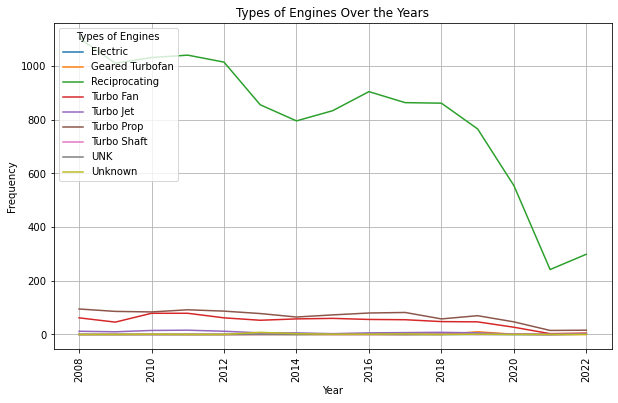

In [217]:
# Want to see engine type based on year 
# Pivot the DataFrame to have each unique number_of_engines as a separate column
pivot_df1 = aviation_2008.pivot_table(index='Year', columns='Engine.Type', aggfunc='size', fill_value=0)

# Create a line plot for each column
plt.figure(figsize=(10, 6))
for column in pivot_df1.columns:
    plt.plot(pivot_df1.index, pivot_df1[column], label=f'{column}')

plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Types of Engines Over the Years')
plt.legend(title='Types of Engines', loc='upper left')
plt.grid(True)
plt.xticks(rotation = 90)

# Show the plot
plt.show()

### Group the DataFrame by 'Make' and find the maximum values for each group

- We wanted to see a data frame columns by make, number of engines and total injuries to compare single engines total injury by looking at the make. 

In [218]:
# Cleaning 'Make' column by changing values with .upper()
aviation_2008['Make'] = aviation_2008['Make'].map(lambda x : x.upper())

In [230]:
# Filter rows where 'Number.of.Engines' is equal to 1
df = aviation_2008[aviation_2008['Number.of.Engines'] == 1]

# Select specific columns from the filtered DataFrame
df = df[['Make', 'Number.of.Engines', 'Engine.Type', 'Total.Fatal.Injuries', 'Total.Serious.Injuries']].copy()

# Fill missing values in 'Total.Fatal.Injuries' and 'Total.Serious.Injuries' with 0
df[['Total.Fatal.Injuries', 'Total.Serious.Injuries']] = df[['Total.Fatal.Injuries', 'Total.Serious.Injuries']].fillna(0)

# Calculate 'Total_Injuries' by summing 'Total.Fatal.Injuries' and 'Total.Serious.Injuries'
df['Total_Injuries'] = df['Total.Fatal.Injuries'] + df['Total.Serious.Injuries']

# Group the DataFrame by 'Make' and find the maximum values for each group
result = df.groupby(['Make'])[['Number.of.Engines', 'Engine.Type', 'Total_Injuries']].max()

# Reset the index to have a clean DataFrame
result = result.reset_index()


In [233]:
# Sort the DataFrame 'result' by the 'Total_Injuries' column in descending order.
sorted_result = result.sort_values(by='Total_Injuries', ascending=False)

# Display the top 10 rows of the sorted DataFrame.
sorted_result.head(10)

,Make,Number.of.Engines,Engine.Type,Total_Injuries
501,PILATUS,1.0,Turbo Prop,14.0
138,CESSNA,1.0,Unknown,12.0
217,DEHAVILLAND,1.0,Turbo Shaft,10.0
504,PIPER,1.0,Unknown,7.0
215,DE HAVILLAND,1.0,Turbo Prop,7.0
612,SOCATA,1.0,Turbo Prop,6.0
503,PILATUS AIRCRAFT LTD,1.0,Turbo Prop,6.0
463,NEIVA,1.0,Reciprocating,6.0
158,CIRRUS DESIGN CORP,1.0,Turbo Fan,5.0
98,BEECH,1.0,Turbo Prop,5.0


In [234]:
# Display the bottom 10 rows of the sorted DataFrame.
sorted_result.tail(10)

,Make,Number.of.Engines,Engine.Type,Total_Injuries
193,CUB CRAFTERS INC,1.0,Reciprocating,0.0
461,NAVAL AIRCRAFT FACTORY,1.0,Reciprocating,0.0
460,NASA AMES RESEARCH CENTER,1.0,Reciprocating,0.0
194,CUBCRAFTER,1.0,Reciprocating,0.0
197,"CUBCRAFTERS, INC",1.0,Reciprocating,0.0
457,NAKAJIMA,1.0,Reciprocating,0.0
456,N126C LLC,1.0,Reciprocating,0.0
201,CURTISS-WRIGHT,1.0,Reciprocating,0.0
205,CZECH SPORT AIRCRAFT,1.0,Reciprocating,0.0
722,ZLIN AVIATION,1.0,Reciprocating,0.0


### Total Injuries by each engine type 

In [241]:
# # Group the filtered DataFrame 'aviation_engine' by the 'Engine.Type' column 
# and calculate the sum of 'Total_Injuries' for each engine type.
aviation_engine.groupby("Engine.Type")["Total_Injuries"].sum()

Engine.Type
Electric          0.0
Reciprocating    12.0
Turbo Fan        32.0
Turbo Jet        12.0
Turbo Prop        0.0
Name: Total_Injuries, dtype: float64

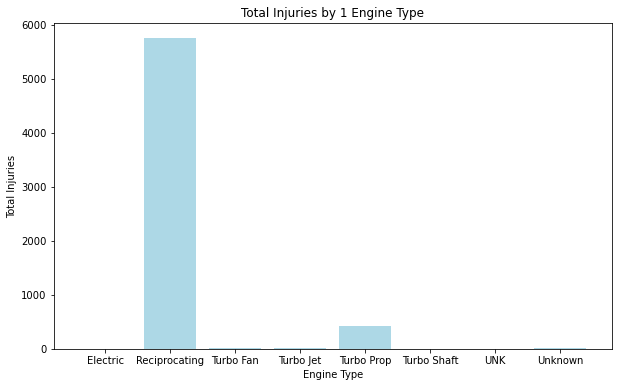

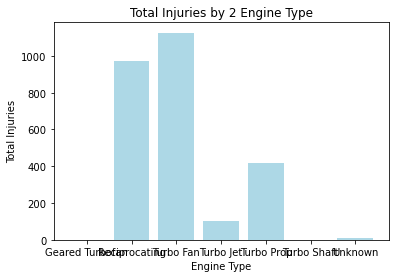

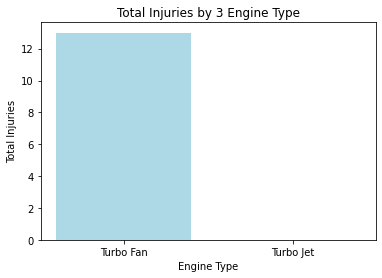

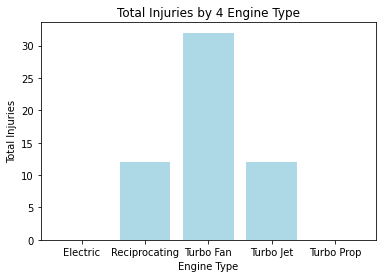

In [240]:
# Create a new figure with a specified size (width: 10 units, height: 6 units).
plt.figure(figsize=(10, 6))

# Iterate through a list of engine numbers [1, 2, 3, 4].
for engine in [1, 2, 3, 4]:
    
    # Filter the 'aviation_2008' DataFrame to select rows where the 'Number.of.Engines' column matches the current 'engine'.
    aviation_engine = aviation_2008[aviation_2008['Number.of.Engines'] == engine]

    # Extract the engine types and corresponding total injuries as arrays.
    engine_type = aviation_engine.groupby("Engine.Type")["Total_Injuries"].sum().index
    injuries = aviation_engine.groupby("Engine.Type")["Total_Injuries"].sum().values
    
    # Create a bar chart with engine types on the x-axis and total injuries on the y-axis, using a light blue color for the bars.
    plt.bar(engine_type, injuries, color='lightblue')
    
    # Add a label to the x-axis.
    plt.xlabel('Engine Type')
    
    # Add a label to the y-axis.
    plt.ylabel('Total Injuries')
    
    # Set the title of the current plot based on the 'engine' variable.
    plt.title(f'Total Injuries by {engine} Engine Type')
    
    # Display the current plot.
    plt.show()

- As seen above, reciprocating is the worst engine type, main cause of an accident
- Within our budget, single engine is an option and turbofan is a 15X safer option than reciprocating

### Top 6 single engine turboprob engine type manufacturers

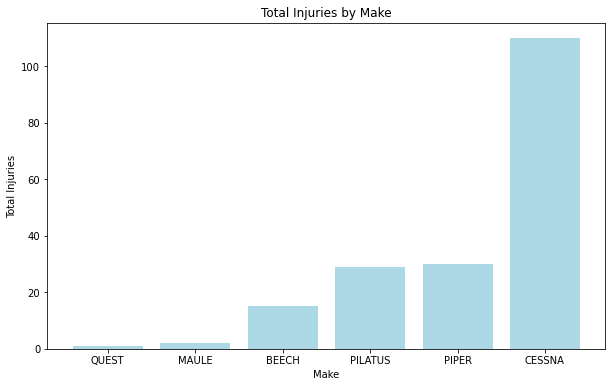

In [247]:
# Initialize empty lists 'x' and 'y' to store data for plotting.
x = []
y = []

# Filter the 'aviation_2008' DataFrame to select rows where the 'Number.of.Engines' is 1 and 'Engine.Type' is "Turbo Prop".
aviation_1 = aviation_2008[(aviation_2008['Number.of.Engines'] == 1) & (aviation_2008['Engine.Type'] == "Turbo Prop")]

# Iterate through a list of aircraft makes.
for make in ["QUEST", "MAULE", "BEECH", "PILATUS", "PIPER", "CESSNA"]:
    
    # Filter the 'aviation_1' DataFrame to select rows where the 'Make' matches the current 'make'.
    aviation_engine = aviation_1[aviation_1['Make'] == make]

    # Append the 'make' to the 'x' list and the sum of 'Total_Injuries' to the 'y' list.
    x.append(make)
    y.append(aviation_engine["Total_Injuries"].sum())

# Create a new figure with a specified size (width: 10 units, height: 6 units).
plt.figure(figsize=(10, 6))

# Create a bar chart with 'x' (Make) on the x-axis and 'y' (Total Injuries) on the y-axis, using a light blue color for the bars.
plt.bar(x, y, color='lightblue')

# Add a label to the x-axis.
plt.xlabel('Make')

# Add a label to the y-axis.
plt.ylabel('Total Injuries')

# Set the title of the plot.
plt.title('Total Injuries by Make')

# Display the plot.
plt.show()

- Quest is the least risky among 5 other manufacturers

# Conclusion

We found below, 
- Reciprocating engines are the most dangerous. While single-engine planes can appear dangerous, most of these crashes are tied to reciprocating engines.
- Turbo engines, such as the TurboProp, are 15x safer. 
- Quest makes the safest models of TurboProp Single Engines.

Of all the manufacturers, the safest makes for planes with TurboProp single-engines come from Quest. A well-made, TurboProp, single-engine plane is our recommendation for starting a new venture under $5 million.

They also represent less economic risk when entering a new market

# Future Insights

- Look into industry norms, like leasing planes.

- Analyze comprehensive flight data, such as total number of flights.

- If this venture proves successful, expand budget and look into planes with two or more engines.

## Source

How much Do Airplanes Cost: https://pilotinstitute.com/how-much-do-airplanes-cost/#:~:text=General%20Aviation%20Airplanes%3A%20%24100%2C000%20–%20%241%2C000%2C000,%2480%20million%20–%20over%20%24200%20million

Piston vs. Turbo: https://www.mercuryjets.com/piston-vs-turbo/

ChatGPT

Leasing Planes: https://simpleflying.com/how-airlines-pay-for-planes/